In [1]:
%load_ext autoreload
%autoreload 2

#### Step 3: Perform Segmentation Inference on Test Dataset

With a trained model in hand, it's time to move forward with making predictions. In this step, you will execute model inference using a checkpoint from a saved epoch, allowing you to evaluate the model's performance on your test dataset.

In [4]:
from ipywidgets import interact, IntSlider, fixed
from model_explore import io, visualization_tools
from model_explore.pytorch import segmentation
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from model_explore import io
from tqdm import tqdm
import torch, copick
import numpy as np

########### Input Parameters ###########

config = "/mnt/simulations/drafts/ml_challenge/ml_config.json"
tomo_algorithm = 'wbp'
voxel_size = 10
# Lets Run Inference on a few tomograms that were held out for testing
# If we set runIDs = None, then we will run inference on all tomograms in the project.
run_ids = ['TS_4', 'TS_17'] 
tomo_batch_size = 5

# Model Parameters (we can read these parameters from results/training_parameters.json)
model_weights = 'results/best_metric_model.pth'
model_type = 'Unet'
channels = [32, 64, 128, 128]
strides = [2, 2, 1]
res_units = 2
Nclass = 8
dim_in = 96

# Output Save Information (Segmentation Name, UserID, SessionID)
seg_info = ['predict', 'DeepFindET', '1']

#### Create the Dataloader and Run Inference with the Model

	
Now let's use our model to create some segmentation predictions. In this notebook, we'll use the function, but for those interested, the equivalent CLI command is `inference`. To see all available options, you can run `inference --help`.

Instead of running inference on the entire CoPick project, we'll specify the runs that were reserved for evaluation in the test dataset, ensuring that our model is only tested on data it hasn't seen before.

In [3]:
print("Using Single-GPU Predictor.")
predict = segmentation.Predictor(
    config,
    model_weights,
    model_type=model_type,
    my_channels=channels,
    my_strides=strides,
    my_num_res_units=res_units,
    my_nclass=Nclass,
    dim_in=dim_in
)

# Run batch prediction
predict.batch_predict(
    runIDs=run_ids,
    num_tomos_per_batch=tomo_batch_size,
    tomo_algorithm=tomo_algorithm,
    voxel_spacing=voxel_size,
    segmentation_name=seg_info[0],
    segmentation_user_id=seg_info[1],
    segmentation_session_id=seg_info[2]
)

Using Single-GPU Predictor.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/simulations/ml_challenge/ml_config.json'

#### (Optional) Visualize the Segmentation

Let's Create Unique Colormap for the Segmentation

In [5]:
tomo_index = 0

root = copick.from_file(config)
run = root.get_run(run_ids[tomo_index])

vol = io.get_tomogram_array(run, voxel_size, tomo_algorithm)
seg = io.get_segmentation_array(run, voxel_size, seg_info[0], seg_info[2], seg_info[1])

# Example segmentation labels and their corresponding names
seg_labels = {0: 'Background', 1: 'Membrane', 2: 'Apoferritin', 3: 'Beta-Amylase', 
              4: 'Beta-Galactosidase', 5: 'Ribosome', 6: 'Thyroglobulin', 7: 'Virus-Like-Particle'}
num_classes = len(seg_labels)

# Check unique values in segmentation to ensure correct mapping
unique_values = np.unique(seg)

# Dynamically update the labels and colormap based on unique values
seg_labels_filtered = {k: v for k, v in seg_labels.items() if k in unique_values}
num_classes = len(seg_labels_filtered)

# Create a discrete colormap
colors = plt.cm.tab20b(np.linspace(0, 1, num_classes))  # You can use other colormaps like 'Set3', 'tab20', etc.
cmap = mcolors.ListedColormap(colors)
bounds = list(seg_labels_filtered.keys()) + [max(seg_labels_filtered.keys())]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

AttributeError: 'NoneType' object has no attribute 'get_voxel_spacing'

Now Let's Display One of the Prediction Segmentations

In [ ]:
# Create an interactive slider for vol_slice
tomo_index = 0

root = copick.from_file(config)
run = root.get_run(run_ids[tomo_index])

vol = io.get_tomogram_array(run, voxel_size, tomo_algorithm)
seg = io.get_segmentation_array(run, voxel_size, seg_info[0], seg_info[2], seg_info[1])

# Get the number of slices for the slider range
max_slices = vol.shape[0] - 1
middle_slice = int(max_slices // 2)

interact(
    visualization_tools.show_tomo_segmentation, 
    tomo=fixed(vol), seg=fixed(seg), 
    vol_slice=IntSlider(min=0, max=max_slices, step=1, value=middle_slice)
)

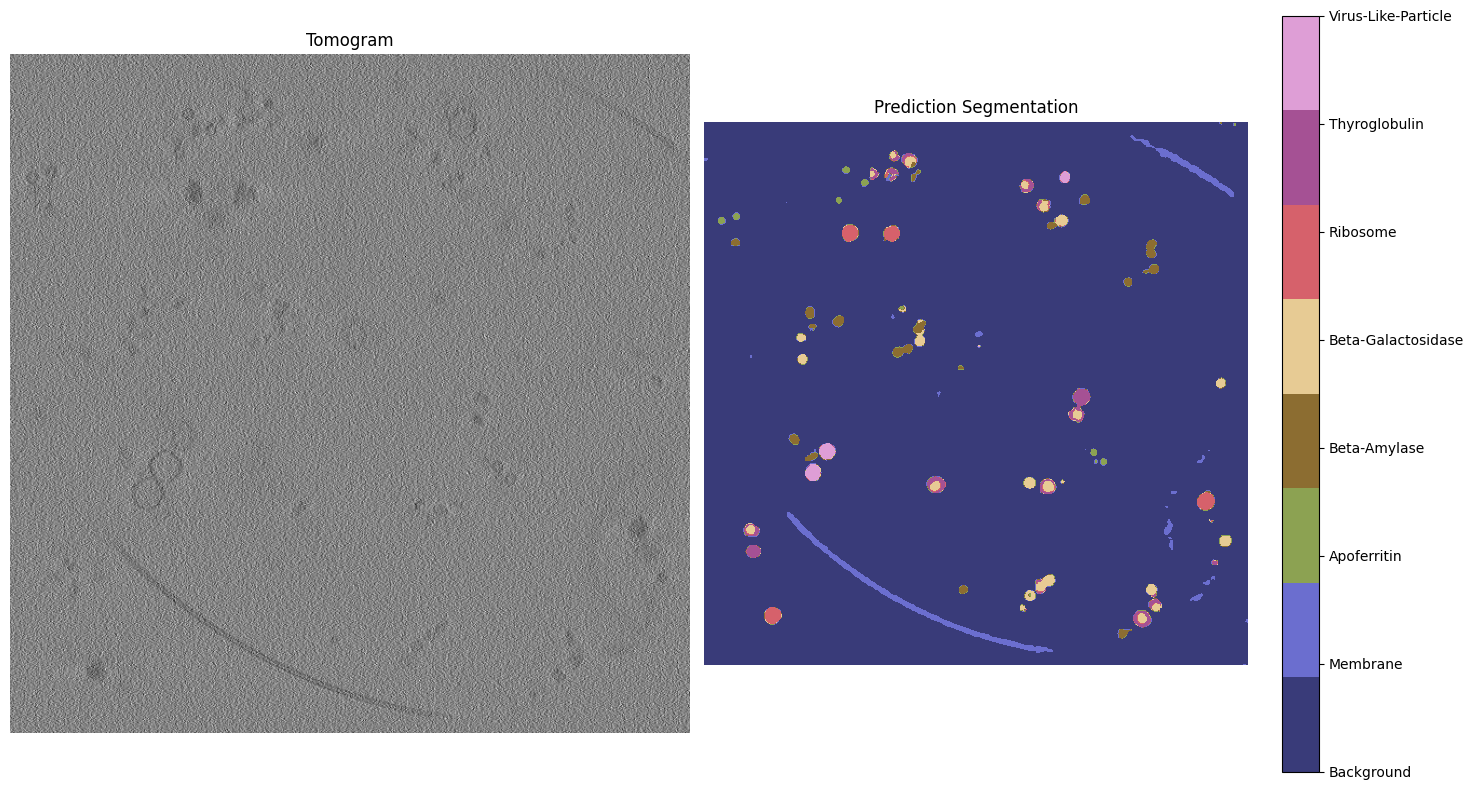

In [53]:
# Plot the images
plt.figure(figsize=(15, 8))

# Tomogram plot
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(vol[vol_slice], cmap='gray')
plt.axis('off')

# Prediction segmentation plot
plt.subplot(1, 2, 2)
plt.title('Prediction Segmentation')
im = plt.imshow(seg[vol_slice], cmap=cmap)  # Use norm and cmap for segmentation
plt.axis('off')

# Add the labeled color bar
cbar = plt.colorbar(im, ticks=list(seg_labels_filtered.keys()))
cbar.ax.set_yticklabels([seg_labels_filtered[i] for i in seg_labels_filtered.keys()])  # Set custom labels

plt.tight_layout()
plt.show()